## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'ravdess-1e5geocomp' #dataset-compression
TRANSFORM = 'stft-strong_intensity' #transform-group
CHANNEL = ''
NUM_BANDS = int(10)

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
strong_intensity_stft_1e5geocomp_ravdess.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'e:\\Research\\UCB\\Strang Lab\\Github\\hierarchical-bayesian-model-validation\\results-audio\\case-studies\\ravdess\\1e5geocomp\\stft\\strong_intensity'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'erb' in TRANSFORM:
    group_data_map.popitem()
NUM_BANDS = max(min(NUM_BANDS, len(group_data_map) - 2), 1)

In [7]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
#GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // NUM_BANDS, 1)]
GROUPS = np.linspace(2, sorted(group_data_map)[-1], NUM_BANDS, dtype=int)


cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map


Running 12760 CDFs


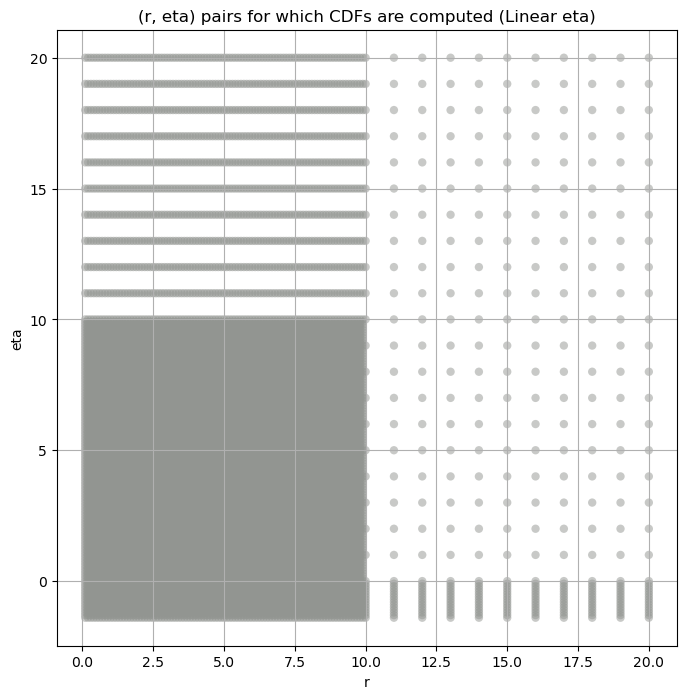

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [8]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [9]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [10]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var  var_lower  var_upper     obs_kurt  kurt_lower  kurt_upper  \
band                                                                         
2     57.704780  47.476635  76.398020    85.819220   20.804083   325.88730   
3     28.217304  23.017448  38.998640   109.013954   22.600456   428.96490   
4     19.802885  15.805842  27.547457   119.686070   31.191708   448.51685   
5     11.860390   9.280744  16.449108   127.357480   39.895786   435.14180   
6      9.950483   7.310499  18.875906   489.406600   41.010380  1448.79970   
7      3.988397   3.037800   5.719976   155.192670   44.948450   511.73193   
8      1.212791   0.702662   4.294569  3882.218500   40.366207  4814.17040   
9      0.259110   0.182862   0.496471   520.751400   54.998947  1529.40590   

      total_samples  
band                 
2        12192660.0  
3        14450560.0  
4        17611620.0  
5        20772680.0  
6        24836900.0  
7        29804280.0  
8        35674820.0  
9        57350660.0

## Initial Grid Search and Hypothesis Test Plots

In [11]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [12]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
band                                                             
2     57.704780      57.704781       50.249359       47.455997   
3     28.217304      28.217304       24.385292       22.969461   
4     19.802885      19.802885       17.006474       15.865411   
5     11.860390      11.860390       10.031480        9.254699   
6      9.950483       9.950483        7.916701        7.303150   
7      3.988397       3.988397        3.288534        3.008035   
8      1.212791       1.212791        0.759404        0.699004   
9      0.259110       0.259110        0.199237        0.179915   

      var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
band                                                                      
2          45.429073        43.802174        41.218987        39.175110   
3          21.932133        21.094940        19.769222        18.722170   
4          15.009015        14.307560        13.188201        12.304936   
5           8.674818         8.204055         7.458313         6.874269   
6           6.842695         6.466697         5.865690         5.392845   
7           2.803448         2.639373         2.382879         2.184911   
8           0.654752         0.619105         0.562888         0.519019   
9           0.165780         0.154496         0.137046         0.123807   

      var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
band                                                                      
2           37.469936        35.996723        34.696545        31.505785  
3           17.850712        17.103186        16.447912        14.855029  
4           11.572589        10.948602        10.405054         9.106694  
5            6.394142         5.987252         5.635197         4.804873  
6            5.002136         4.670033         4.382294         3.702374  
7            2.023653         1.888061         1.771574         1.499567  
8            0.483001         0.452538         0.426223         0.364253  
9            0.113234         0.104511         0.097163         0.080578

####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.007014371259003532 57.70478


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.006225970880487042 50.24936


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.005316583121836194 47.455997


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.004703907600454138 45.429073


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.005836662421172603 43.802174


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.003900255144848326 41.218987


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.005302585648244089 39.17511


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.006772027651240187 37.469936


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.007359356808225304 35.996723


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.00634923807637644 34.696545


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.008926108336891364 31.505785
Number of samples: 100000, Without approximation : 12192660.0


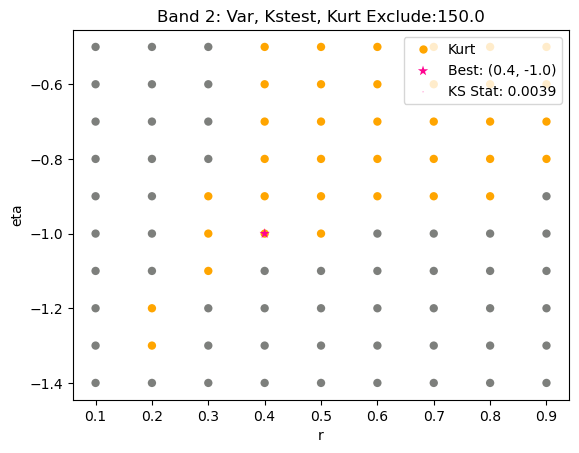

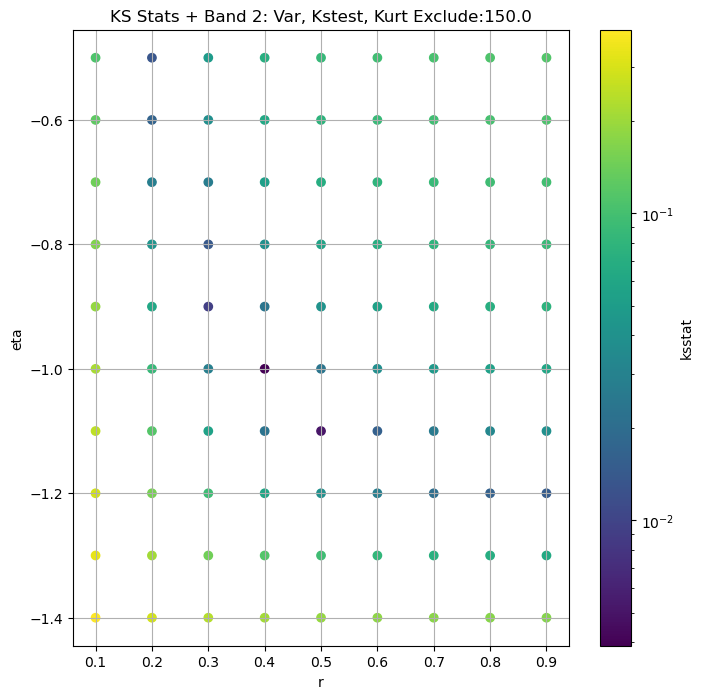

####
Band  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.002512159178925777 28.217304


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.004008066051885972 24.385292


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.006053082028206813 22.969461


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.008095430655796376 21.932133


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.009952897321049148 21.09494


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.00739366944619102 19.769222


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.004502332216300364 18.72217


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.004871570125027022 17.850712


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.006131224791790978 17.103186


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.007503814638066916 16.447912


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.008615479509360115 14.855029
Number of samples: 100000, Without approximation : 14450560.0


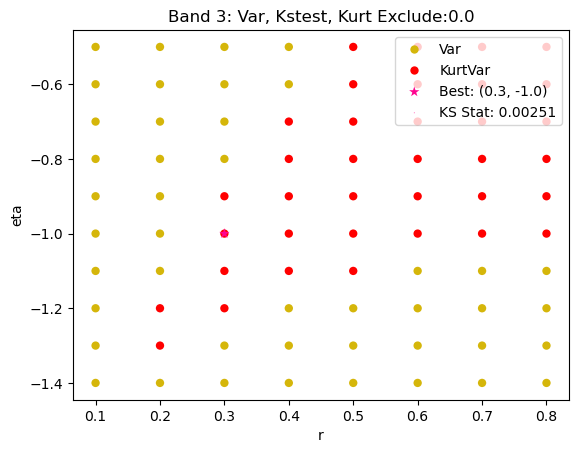

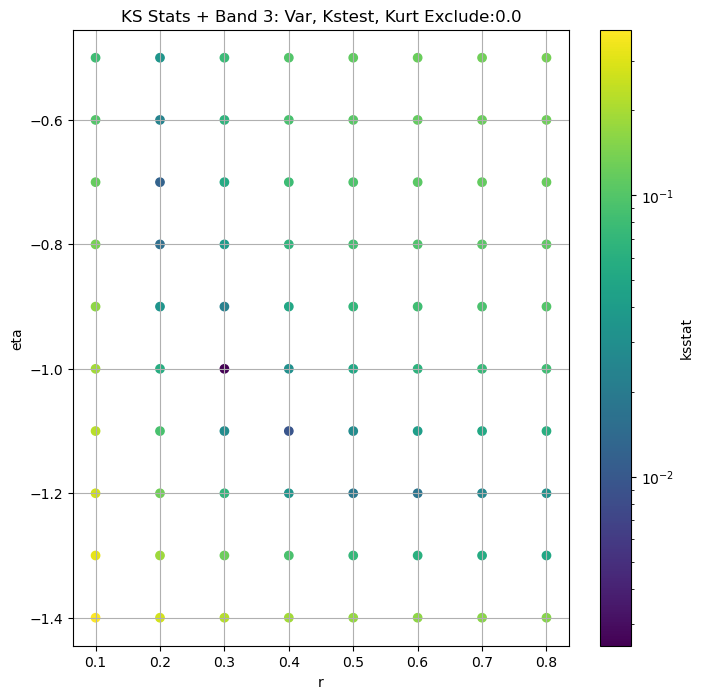

####
Band  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.004896653089777825 19.802885


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.0073365810999208025 17.006474


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.008145144584552733 15.865411


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.008887817838563239 15.009015


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.00995018892416727 14.30756


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.010128400474679888 13.188201


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.010780373176258767 12.304936


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.009979497418811434 11.572589


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.00798151065932462 10.948602


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.00766825938491178 10.405054


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.009049846506942166 9.106694
Number of samples: 100000, Without approximation : 17611620.0


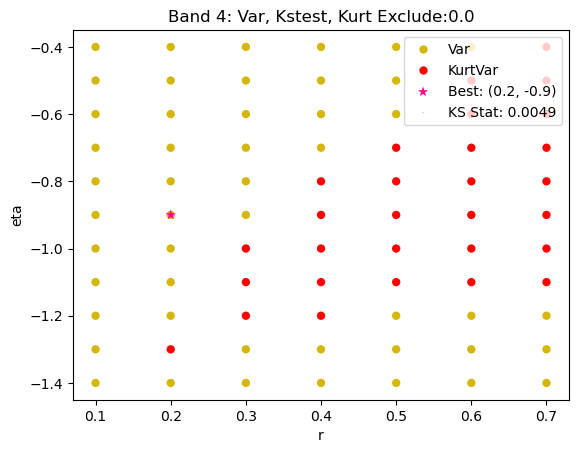

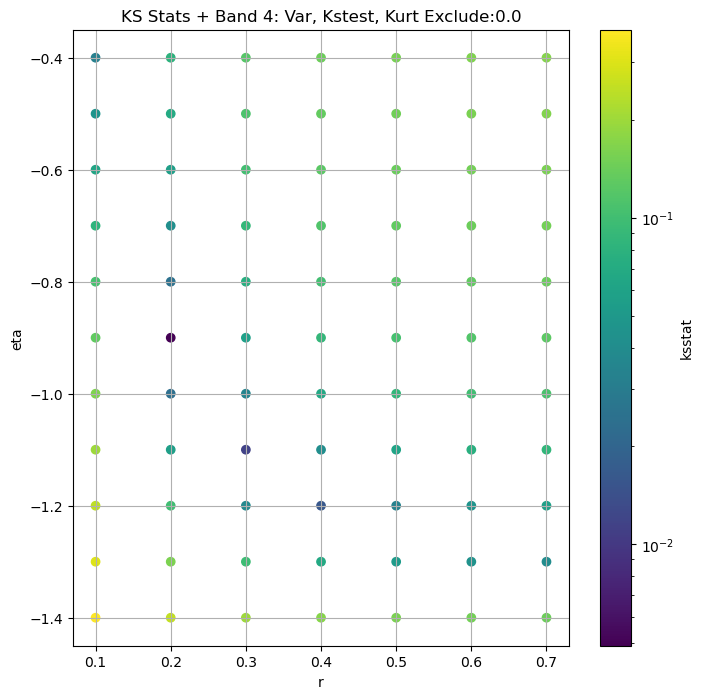

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.00532799465868139 11.86039


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.00985987167619673 10.03148


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.007662132467098126 9.254699


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.004928284070982114 8.674818


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.00347095249722665 8.204055


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.007620739489624329 7.4583125


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.010347978604578922 6.874269


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.007637835412776073 6.394142


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.006894340022065352 5.987252


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.00789900937989518 5.635197


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.008620583561289308 4.8048725
Number of samples: 100000, Without approximation : 20772680.0


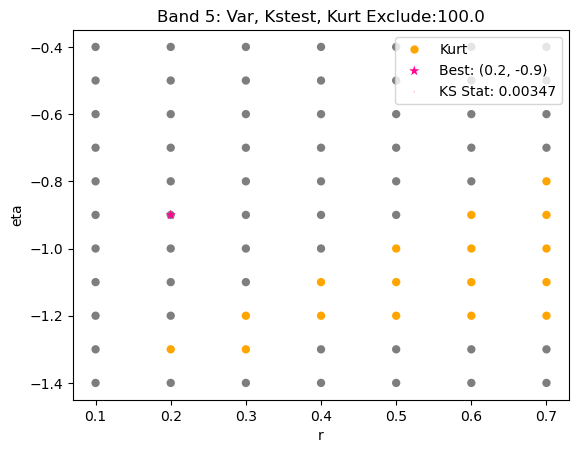

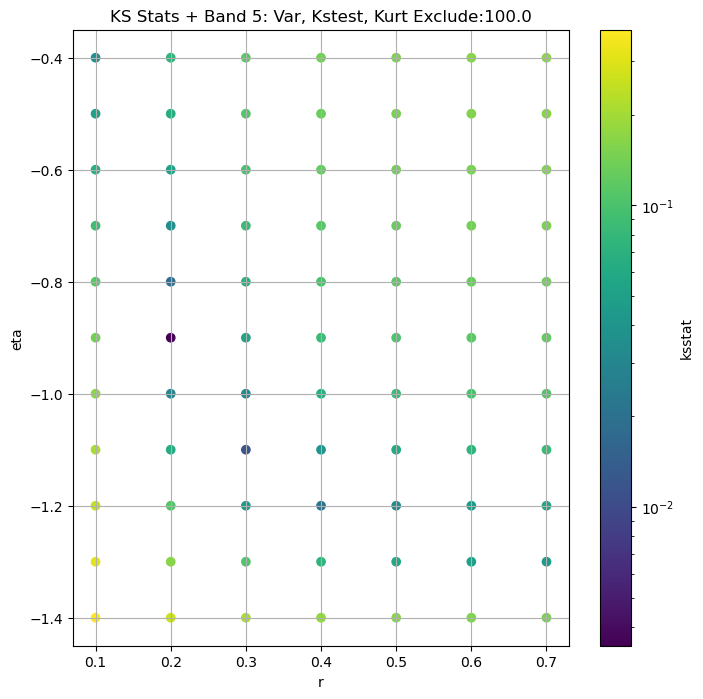

####
Band  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.010321010500060623 9.950483


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.009577777241408902 7.916701


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.007667360064263273 7.30315


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.006112937853257505 6.8426948


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.007889302870575543 6.466697


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.008404714447348638 5.8656898


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.008343386566701305 5.392845


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.006979275852292077 5.002136


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.006545249010562568 4.6700335


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.007302225604729389 4.3822937


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.008348711600329791 3.7023737
Number of samples: 100000, Without approximation : 24836900.0


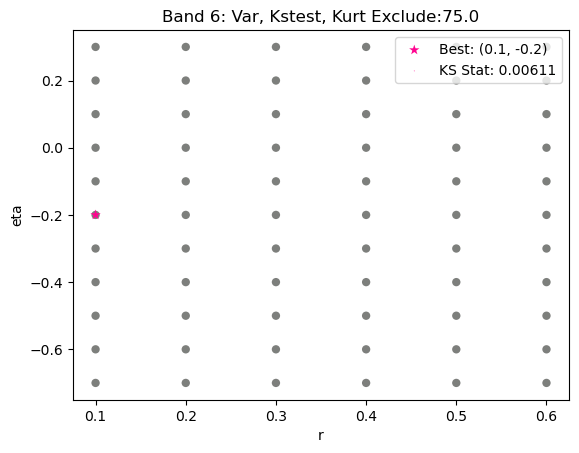

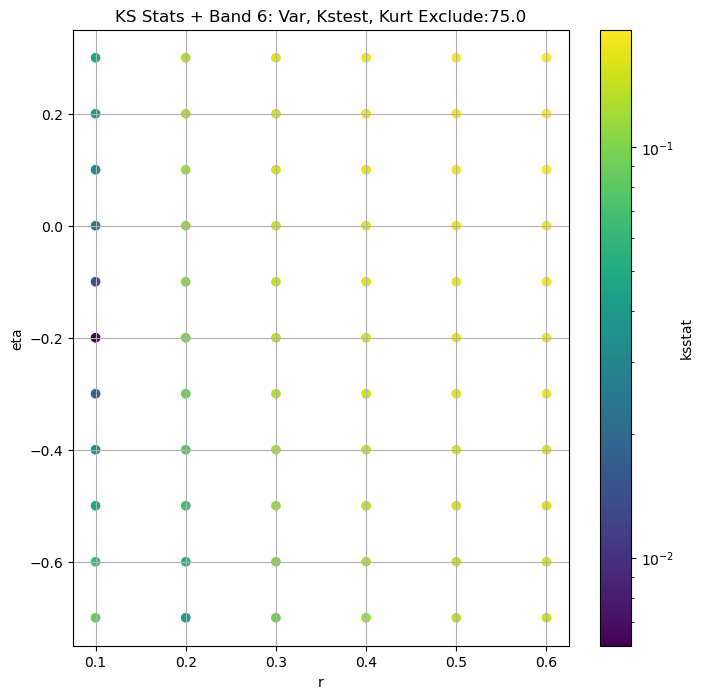

####
Band  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.007589194851785663 3.9883971


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.005998666612600845 3.2885342


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.005785595136773569 3.008035


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.008583364964907858 2.8034482


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.008013529676270559 2.639373


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.008081629666087276 2.3828788


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.007106294238251709 2.1849115


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.0057172042081813194 2.0236533


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.006567049060143271 1.888061


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.008549118252876686 1.7715745


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.008399313625647942 1.4995669
Number of samples: 100000, Without approximation : 29804280.0


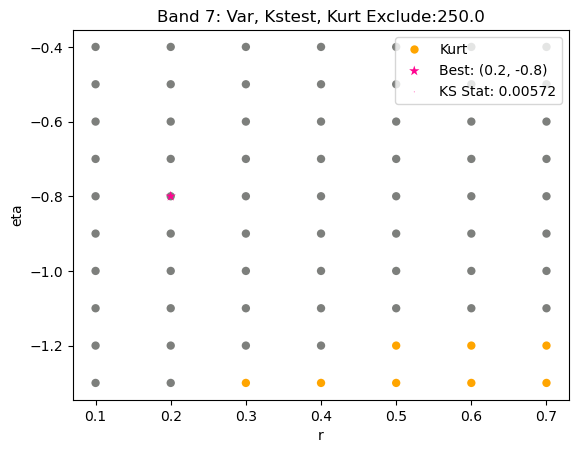

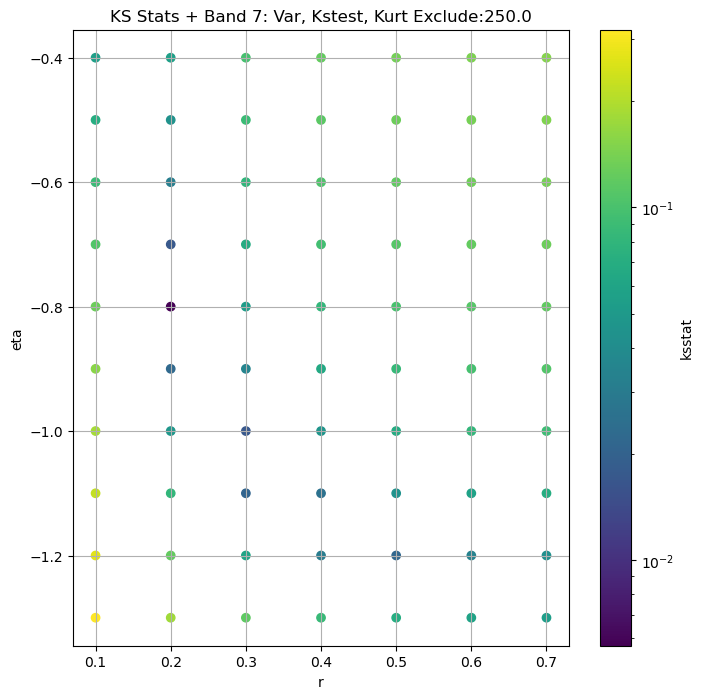

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.012156373939559706 1.2127907


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.003073916512366215 0.75940394


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.006667399253466155 0.6990045


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.004590179535102545 0.6547521


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.004500808170770365 0.61910486


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.005568629730362207 0.5628877


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.006631937586697445 0.51901895


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.0054579342295225895 0.48300138


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.006252565458735036 0.452538


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.007084456920548345 0.42622298


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.00819296792206629 0.36425304
Number of samples: 100000, Without approximation : 35674820.0


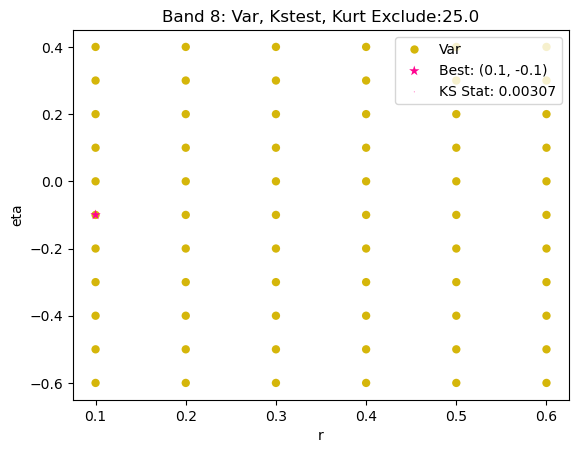

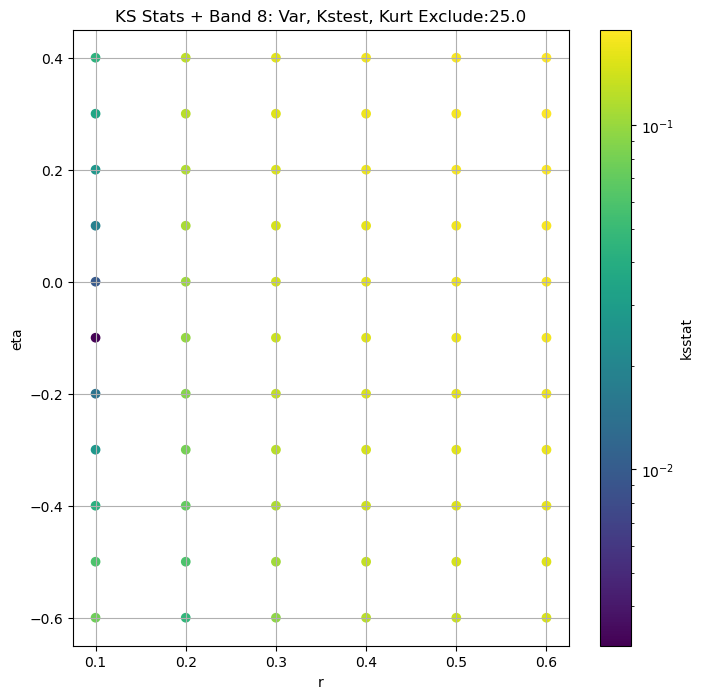

####
Band  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.012196918543973215 0.25911036


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.0068818618611595495 0.19923651


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.005841656501765824 0.17991519


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.0062499326603104866 0.16577956


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.004268283600538658 0.15449587


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.008208174673179247 0.13704567


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.0046235205305952265 0.123807244


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.004912787875807234 0.11323373


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.008798751118182624 0.10451149


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.005547123110831158 0.09716305


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.009541269459106438 0.08057825
Number of samples: 100000, Without approximation : 57350660.0


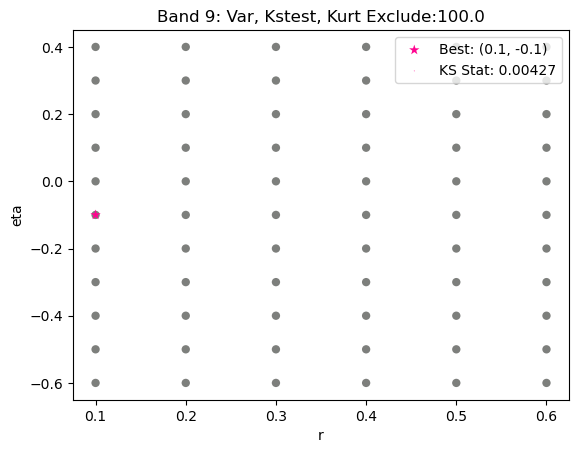

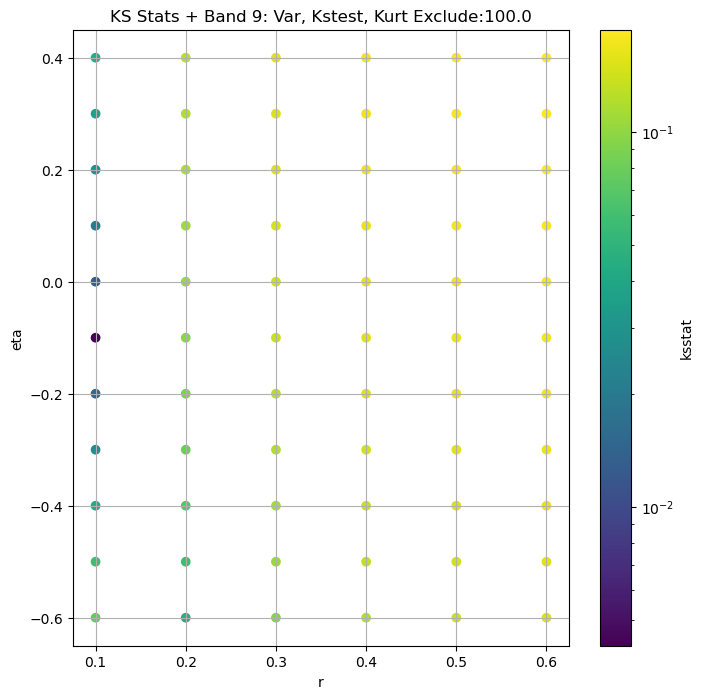

obs_var  var_lower  var_upper     obs_kurt  kurt_lower  kurt_upper  \
band                                                                         
2     57.704780  47.476635  76.398020    85.819220   20.804083   325.88730   
3     28.217304  23.017448  38.998640   109.013954   22.600456   428.96490   
4     19.802885  15.805842  27.547457   119.686070   31.191708   448.51685   
5     11.860390   9.280744  16.449108   127.357480   39.895786   435.14180   
6      9.950483   7.310499  18.875906   489.406600   41.010380  1448.79970   
7      3.988397   3.037800   5.719976   155.192670   44.948450   511.73193   
8      1.212791   0.702662   4.294569  3882.218500   40.366207  4814.17040   
9      0.259110   0.182862   0.496471   520.751400   54.998947  1529.40590   

      total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                               
2        12192660.0             0.003900        0.4         -1.0   
3        14450560.0             0.002512        0.3         -1.0   
4        17611620.0             0.004897        0.2         -0.9   
5        20772680.0             0.003471        0.2         -0.9   
6        24836900.0             0.006113        0.1         -0.2   
7        29804280.0             0.005717        0.2         -0.8   
8        35674820.0             0.003074        0.1         -0.1   
9        57350660.0             0.004268        0.1         -0.1   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      8.447002e+00                   150.0           41.218987   
3      1.061377e+00                     0.0           28.217304   
4      7.858288e-03                     0.0           19.802885   
5      3.255577e-03                   100.0            8.204055   
6      2.916067e-12                    75.0            6.842695   
7      4.792016e-04                   250.0            2.023653   
8      1.829190e-13                    25.0            0.759404   
9      3.721369e-14                   100.0            0.154496   

      kstest_stat_cutoff_0.05  
band                           
2                    0.000389  
3                    0.000357  
4                    0.000324  
5                    0.000298  
6                    0.000273  
7                    0.000249  
8                    0.000227  
9                    0.000179

In [13]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [14]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 2, 150.0 + 100 = 250, ksstat: 0.0048742435936467085, var: 37.46993637084961


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 2, 150.0 + 75 = 225, ksstat: 0.004458261779941755, var: 38.28836441040039


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 2, 150.0 + 50 = 200, ksstat: 0.004040163329149502, var: 39.17510986328125


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 2, 150.0 + 25 = 175, ksstat: 0.003702732408162563, var: 40.14495849609375


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 2, 150.0 + 0 = 150, ksstat: 0.003900255144848326, var: 41.21898651123047


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 2, 150.0 + -25 = 125, ksstat: 0.0032825738292347334, var: 42.42436218261719


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 2, 150.0 + -50 = 100, ksstat: 0.002687857989252831, var: 43.80217361450195


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 2, 150.0 + -75 = 75, ksstat: 0.0020570337809325823, var: 45.429073333740234


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 2, 150.0 + -100 = 50, ksstat: 0.0018412314709185251, var: 47.455997467041016
Number of samples: 100000, Without approximation : 12192660.0


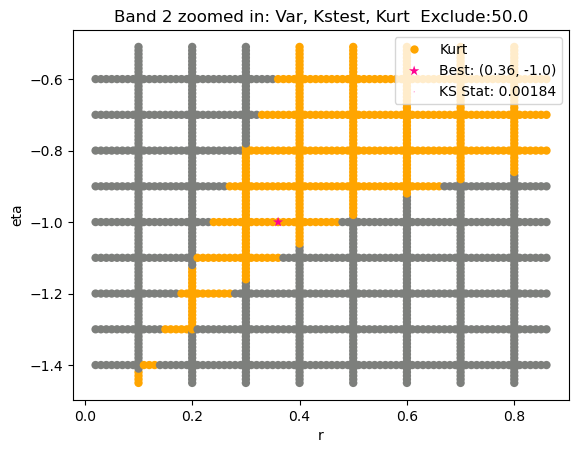

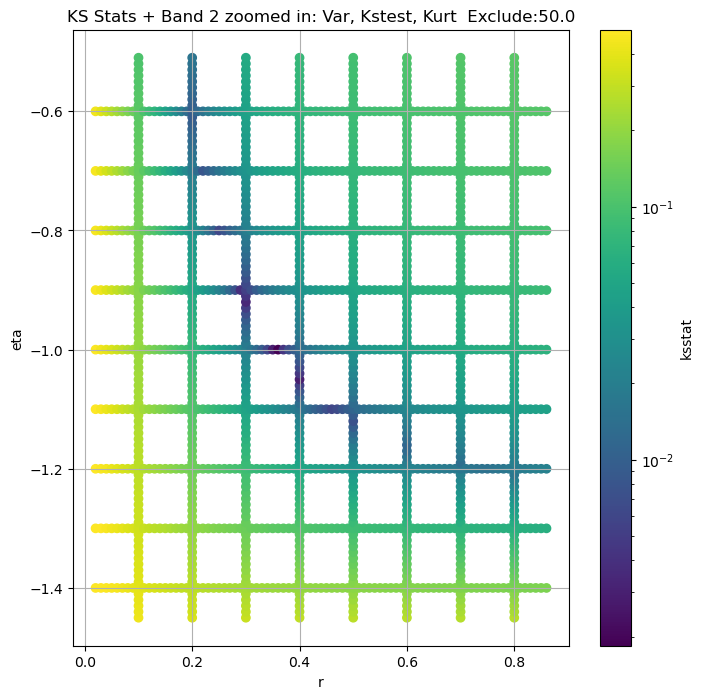

Band 3


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
band 3, 0.0 + 100 = 100, ksstat: 0.002206016147814311, var: 21.094940185546875


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
band 3, 0.0 + 75 = 75, ksstat: 0.001711529658499189, var: 21.932132720947266


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
band 3, 0.0 + 50 = 50, ksstat: 0.0022438022311833117, var: 22.96946144104004


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
band 3, 0.0 + 25 = 25, ksstat: 0.002908233477261768, var: 24.385292053222656


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
band 3, 0.0 + 0 = 0, ksstat: 0.002512159178925777, var: 28.217304229736328
Number of samples: 100000, Without approximation : 14450560.0


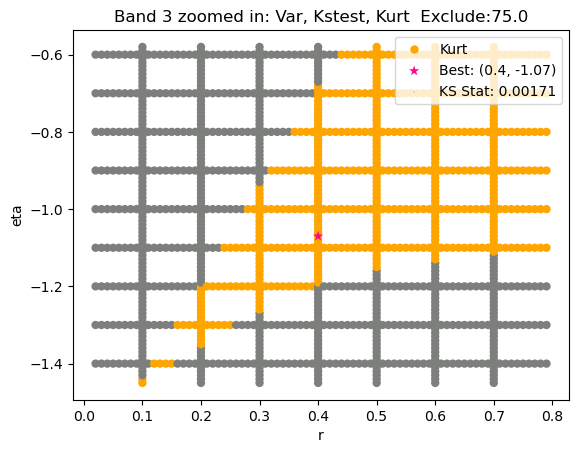

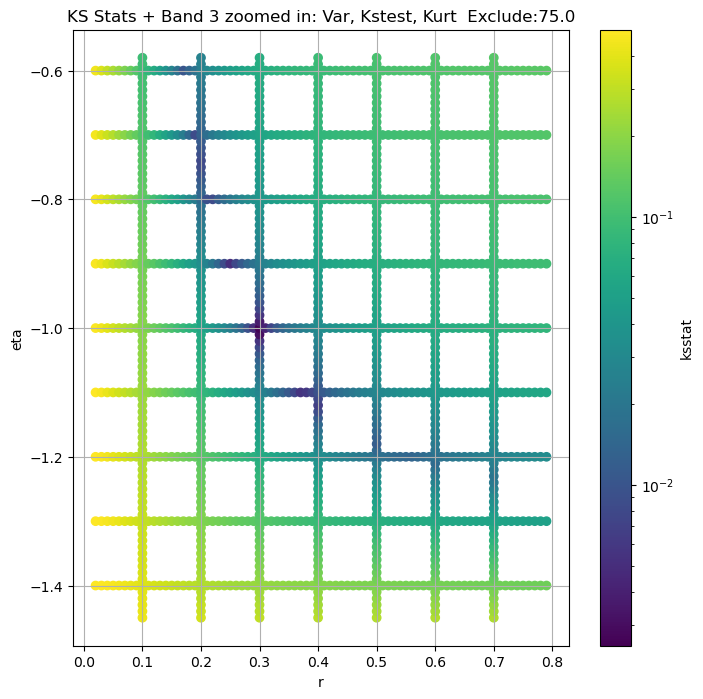

Band 4


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 4, 0.0 + 100 = 100, ksstat: 0.003171337059190888, var: 14.307559967041016


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 4, 0.0 + 75 = 75, ksstat: 0.003948075726667888, var: 15.009015083312988


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 4, 0.0 + 50 = 50, ksstat: 0.0024028632167433783, var: 15.865410804748535


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 4, 0.0 + 25 = 25, ksstat: 0.0031287240420067586, var: 17.006473541259766


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 4, 0.0 + 0 = 0, ksstat: 0.002925317070997413, var: 19.802885055541992
Number of samples: 100000, Without approximation : 17611620.0


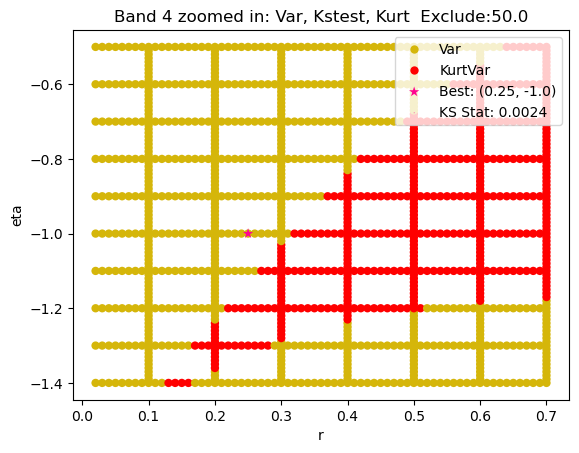

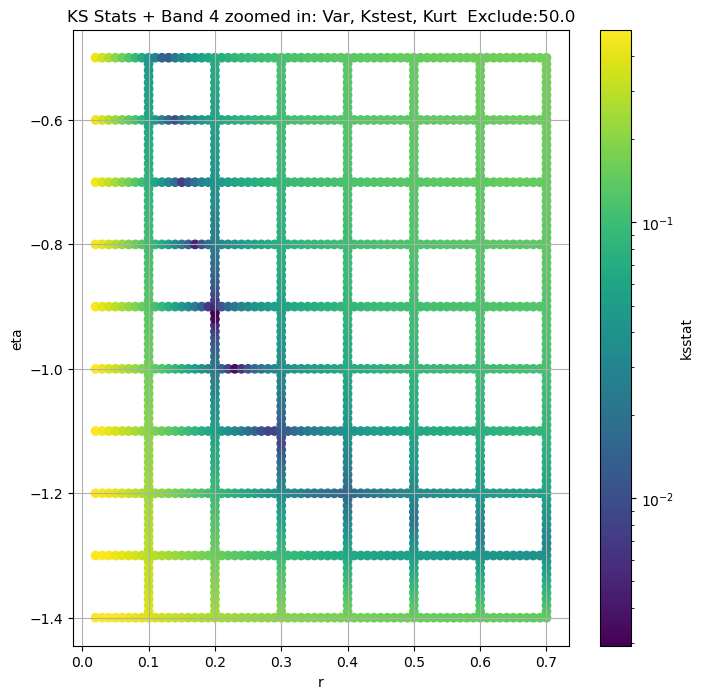

Band 5


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 5, 100.0 + 100 = 200, ksstat: 0.004939165741080345, var: 6.874269008636475


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 5, 100.0 + 75 = 175, ksstat: 0.00473065585497422, var: 7.150601387023926


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 5, 100.0 + 50 = 150, ksstat: 0.004244243787139649, var: 7.458312511444092


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 5, 100.0 + 25 = 125, ksstat: 0.003872435421593868, var: 7.805278301239014


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 5, 100.0 + 0 = 100, ksstat: 0.0034333490282847327, var: 8.204054832458496


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 5, 100.0 + -25 = 75, ksstat: 0.0038073534209391857, var: 8.67481803894043


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 5, 100.0 + -50 = 50, ksstat: 0.003058338501643304, var: 9.254698753356934


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 5, 100.0 + -75 = 25, ksstat: 0.0043211928003935585, var: 10.031479835510254


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 5, 100.0 + -100 = 0, ksstat: 0.005110072242758057, var: 11.860389709472656
Number of samples: 100000, Without approximation : 20772680.0


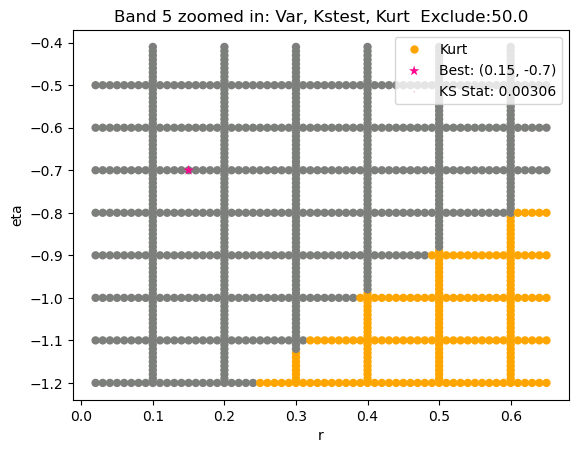

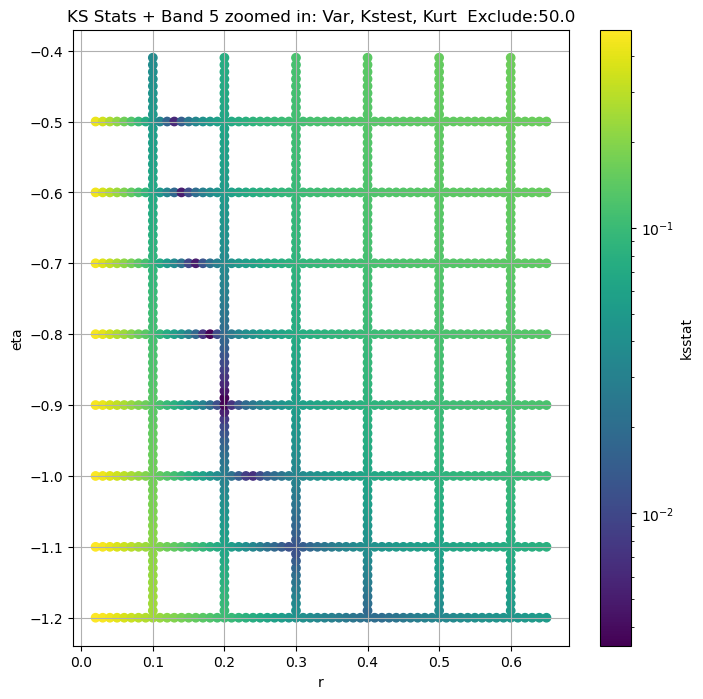

Band 6


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 75.0 + 100 = 175, ksstat: 0.006097088194801592, var: 5.616821765899658


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 75.0 + 75 = 150, ksstat: 0.004821879627988189, var: 5.865689754486084


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 75.0 + 50 = 125, ksstat: 0.004426094444016981, var: 6.145881175994873


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 75.0 + 25 = 100, ksstat: 0.004217795254399491, var: 6.4666972160339355


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 75.0 + 0 = 75, ksstat: 0.005100580231676366, var: 6.8426947593688965


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 75.0 + -25 = 50, ksstat: 0.005332943727721862, var: 7.303150177001953


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 75.0 + -50 = 25, ksstat: 0.004532398374646696, var: 7.916700839996338


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 75.0 + -75 = 0, ksstat: 0.00552803511161537, var: 9.950483322143555
Number of samples: 100000, Without approximation : 24836900.0


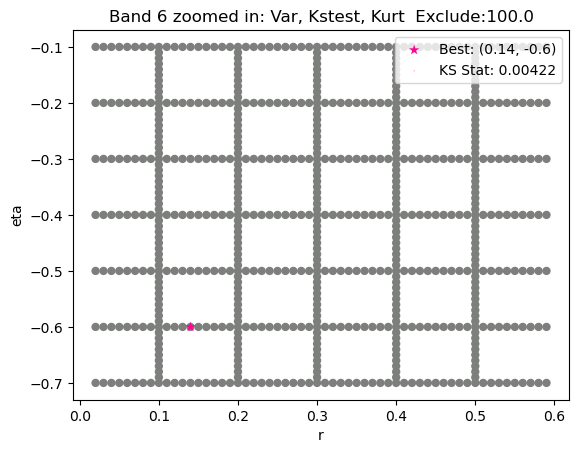

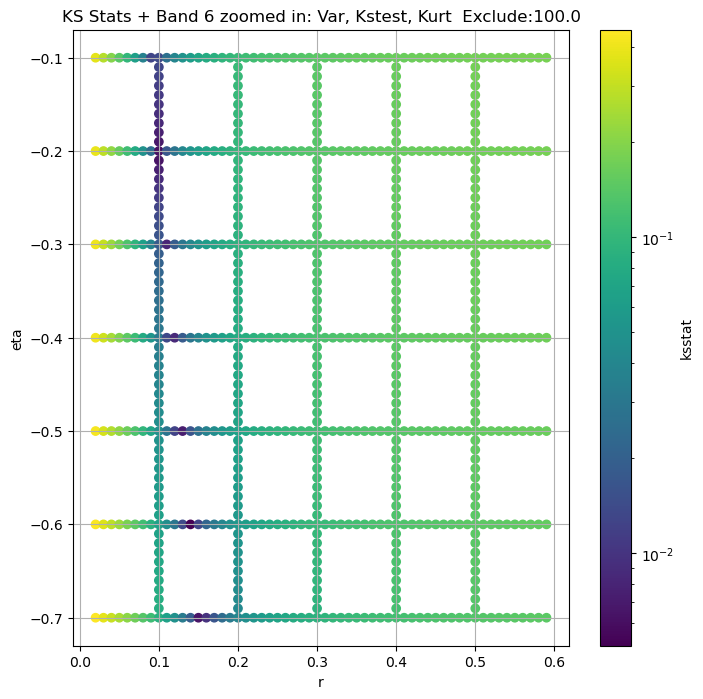

Band 7


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 7, 250.0 + 100 = 350, ksstat: 0.006409441300330998, var: 1.7715744972229004


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 7, 250.0 + 75 = 325, ksstat: 0.006170629650442029, var: 1.8277478218078613


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 7, 250.0 + 50 = 300, ksstat: 0.0060648974645497854, var: 1.8880610466003418


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 7, 250.0 + 25 = 275, ksstat: 0.005831569351945162, var: 1.9531259536743164


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 7, 250.0 + 0 = 250, ksstat: 0.005430260683183781, var: 2.023653268814087


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 7, 250.0 + -25 = 225, ksstat: 0.005290124986349256, var: 2.100525379180908


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 7, 250.0 + -50 = 200, ksstat: 0.004947171499230395, var: 2.1849114894866943


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 7, 250.0 + -75 = 175, ksstat: 0.0046336430575548496, var: 2.2783124446868896


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 7, 250.0 + -100 = 150, ksstat: 0.004691564577742247, var: 2.3828787803649902
Number of samples: 100000, Without approximation : 29804280.0


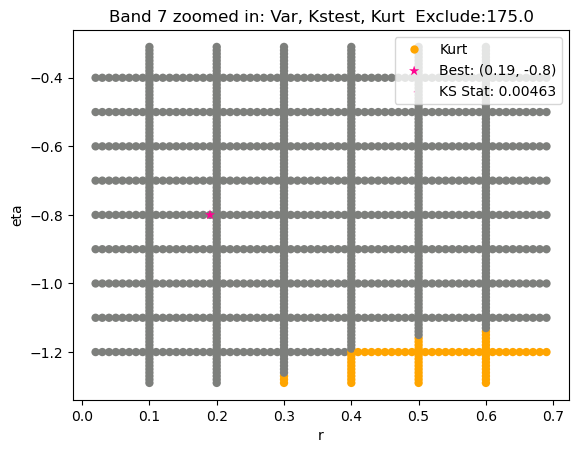

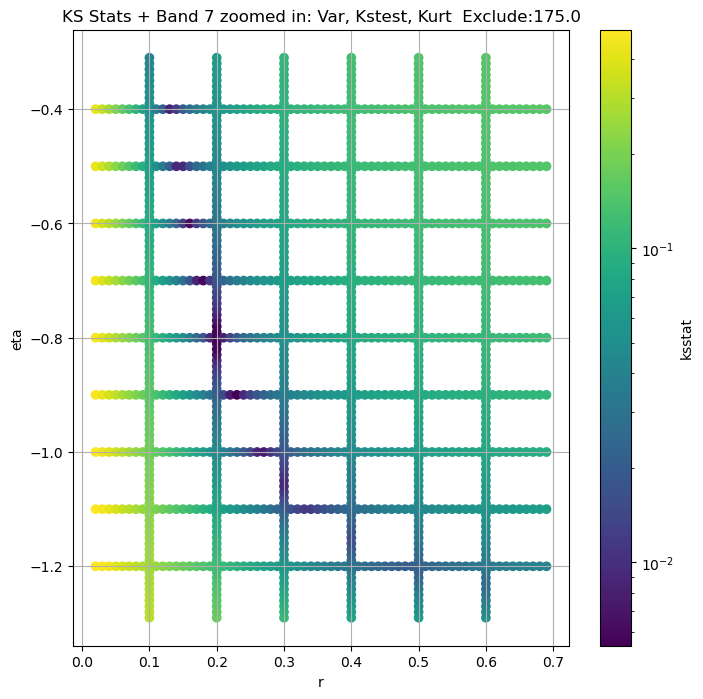

Band 8


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 8, 25.0 + 100 = 125, ksstat: 0.004041721004320098, var: 0.5890174508094788


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 8, 25.0 + 75 = 100, ksstat: 0.004427461783923392, var: 0.6191048622131348


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 8, 25.0 + 50 = 75, ksstat: 0.003251809670980597, var: 0.6547520756721497


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 8, 25.0 + 25 = 50, ksstat: 0.002933948993040867, var: 0.6990044713020325


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 8, 25.0 + 0 = 25, ksstat: 0.003073916512366215, var: 0.7594039440155029


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 8, 25.0 + -25 = 0, ksstat: 0.008487333507025796, var: 1.2127907276153564
Number of samples: 100000, Without approximation : 35674820.0


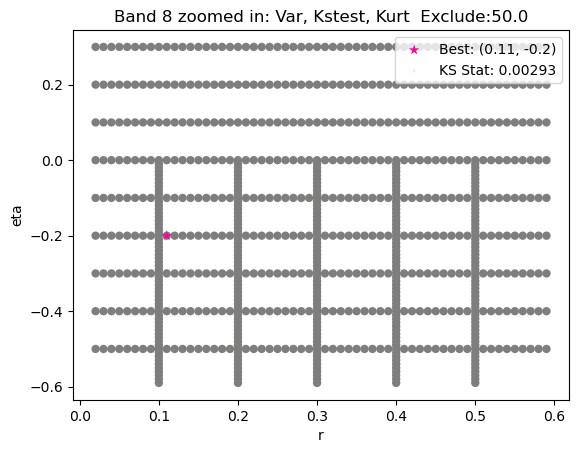

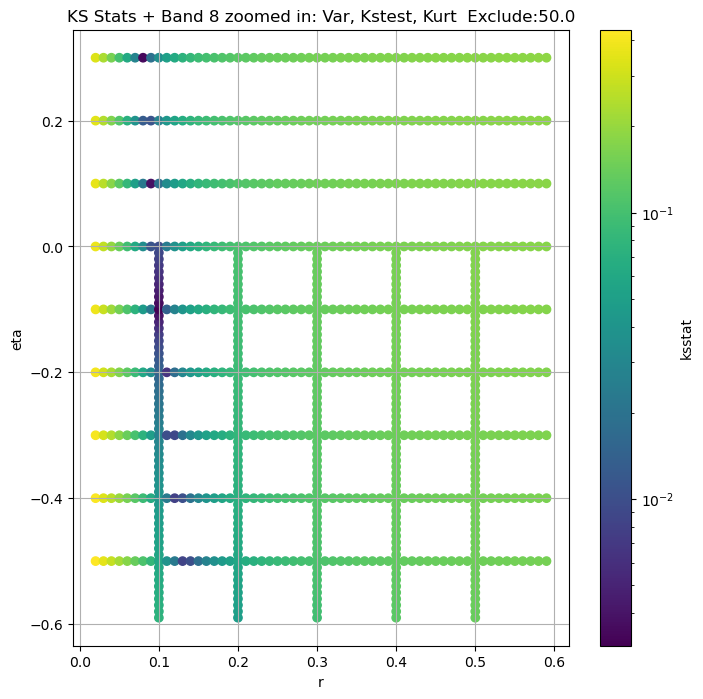

Band 9


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 9, 100.0 + 100 = 200, ksstat: 0.006960476418981704, var: 0.12380724400281906


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 9, 100.0 + 75 = 175, ksstat: 0.004033744919488241, var: 0.13002236187458038


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 9, 100.0 + 50 = 150, ksstat: 0.003554160584650707, var: 0.13704566657543182


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 9, 100.0 + 25 = 125, ksstat: 0.00450542102827467, var: 0.14509449899196625


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 9, 100.0 + 0 = 100, ksstat: 0.004268283600538658, var: 0.15449586510658264


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 9, 100.0 + -25 = 75, ksstat: 0.0035411097884769926, var: 0.16577956080436707


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 9, 100.0 + -50 = 50, ksstat: 0.003761263213093363, var: 0.179915189743042


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 9, 100.0 + -75 = 25, ksstat: 0.00515115262213478, var: 0.19923651218414307


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 9, 100.0 + -100 = 0, ksstat: 0.007951534767298152, var: 0.25911036133766174
Number of samples: 100000, Without approximation : 57350660.0


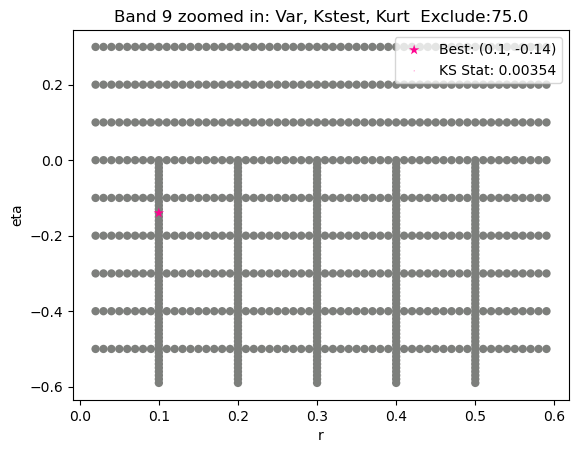

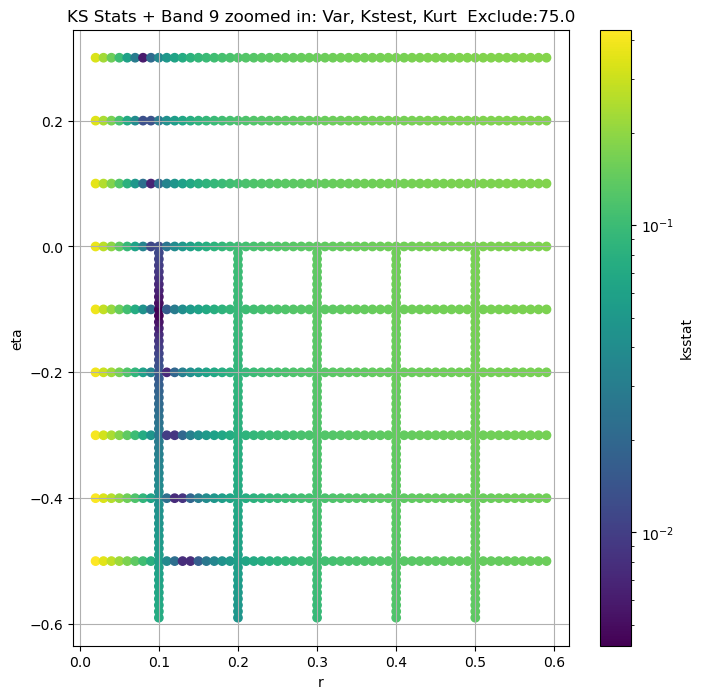

obs_var  var_lower  var_upper     obs_kurt  kurt_lower  kurt_upper  \
band                                                                         
2     57.704780  47.476635  76.398020    85.819220   20.804083   325.88730   
3     28.217304  23.017448  38.998640   109.013954   22.600456   428.96490   
4     19.802885  15.805842  27.547457   119.686070   31.191708   448.51685   
5     11.860390   9.280744  16.449108   127.357480   39.895786   435.14180   
6      9.950483   7.310499  18.875906   489.406600   41.010380  1448.79970   
7      3.988397   3.037800   5.719976   155.192670   44.948450   511.73193   
8      1.212791   0.702662   4.294569  3882.218500   40.366207  4814.17040   
9      0.259110   0.182862   0.496471   520.751400   54.998947  1529.40590   

      total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                               
2        12192660.0             0.003900        0.4         -1.0   
3        14450560.0             0.002512        0.3         -1.0   
4        17611620.0             0.004897        0.2         -0.9   
5        20772680.0             0.003471        0.2         -0.9   
6        24836900.0             0.006113        0.1         -0.2   
7        29804280.0             0.005717        0.2         -0.8   
8        35674820.0             0.003074        0.1         -0.1   
9        57350660.0             0.004268        0.1         -0.1   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      8.447002e+00                   150.0           47.455997   
3      1.061377e+00                     0.0           21.932133   
4      7.858288e-03                     0.0           15.865411   
5      3.255577e-03                   100.0            9.254699   
6      2.916067e-12                    75.0            6.466697   
7      4.792016e-04                   250.0            2.278312   
8      1.829190e-13                    25.0            0.699004   
9      3.721369e-14                   100.0            0.165780   

      kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
band                                                                
2                    0.000389          0.001841    0.36     -1.00   
3                    0.000357          0.001712    0.40     -1.07   
4                    0.000324          0.002403    0.25     -1.00   
5                    0.000298          0.003058    0.15     -0.70   
6                    0.000273          0.004218    0.14     -0.60   
7                    0.000249          0.004634    0.19     -0.80   
8                    0.000227          0.002934    0.11     -0.20   
9                    0.000179          0.003541    0.10     -0.14   

        best_scale  best_exclude_cutoff  n_pval_0.05  
band                                                  
2     5.674268e+00                 50.0       571530  
3     5.838624e+00                 75.0       642970  
4     1.322118e-01                 50.0       309577  
5     9.303887e-06                 50.0       205392  
6     7.973980e-07                100.0       109146  
7     2.589221e-04                175.0        87316  
8     9.692276e-12                 50.0       209031  
9     4.996840e-14                 75.0       141763

In [15]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

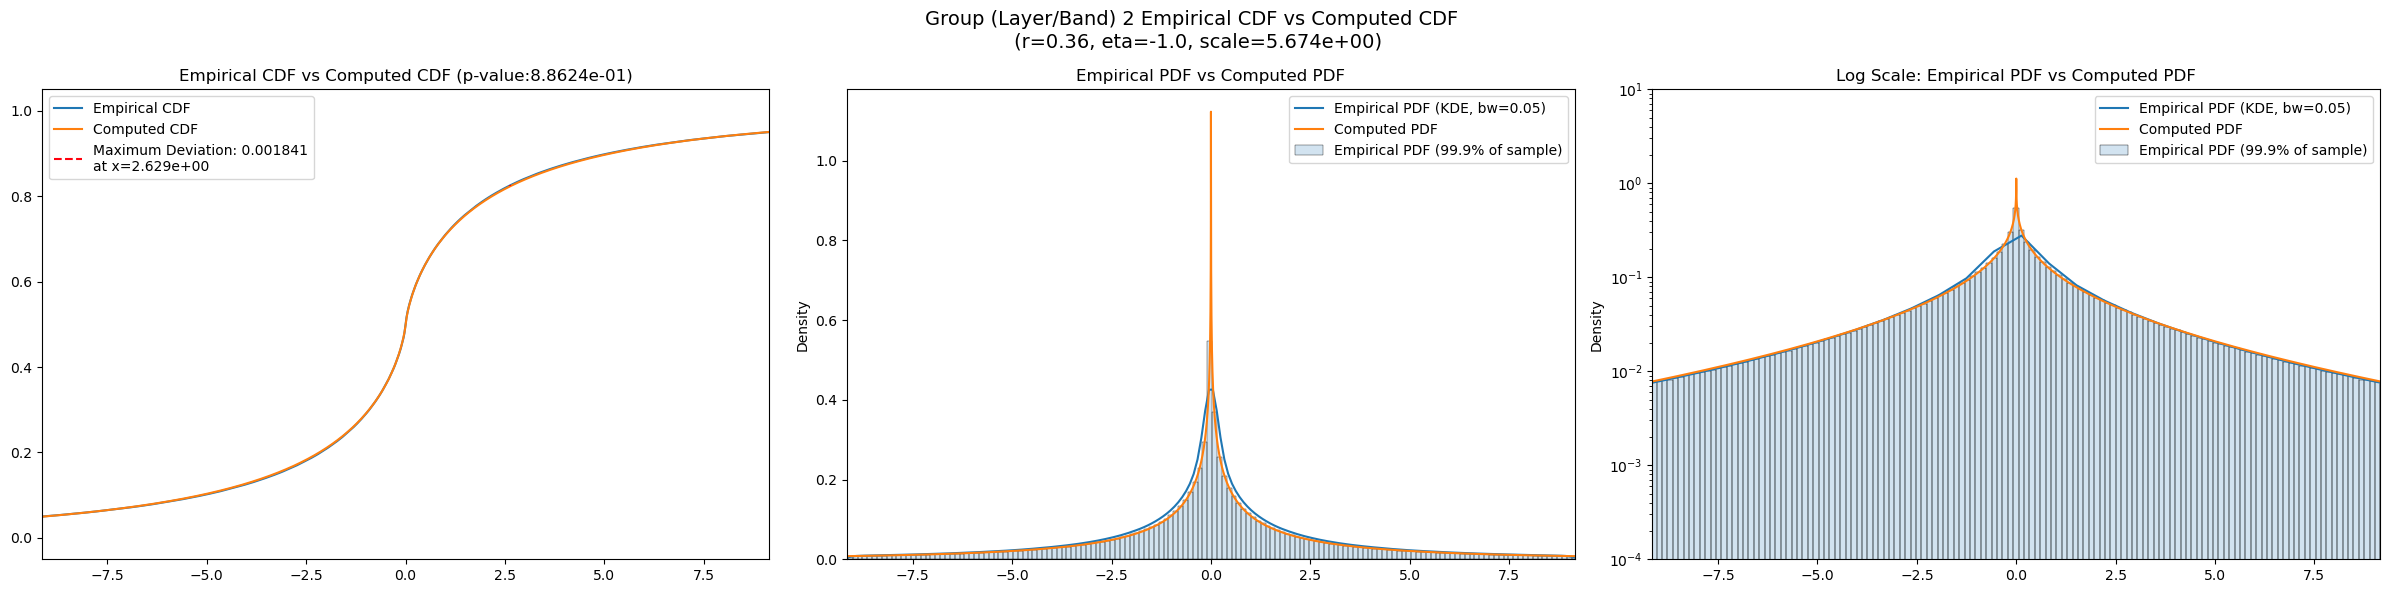

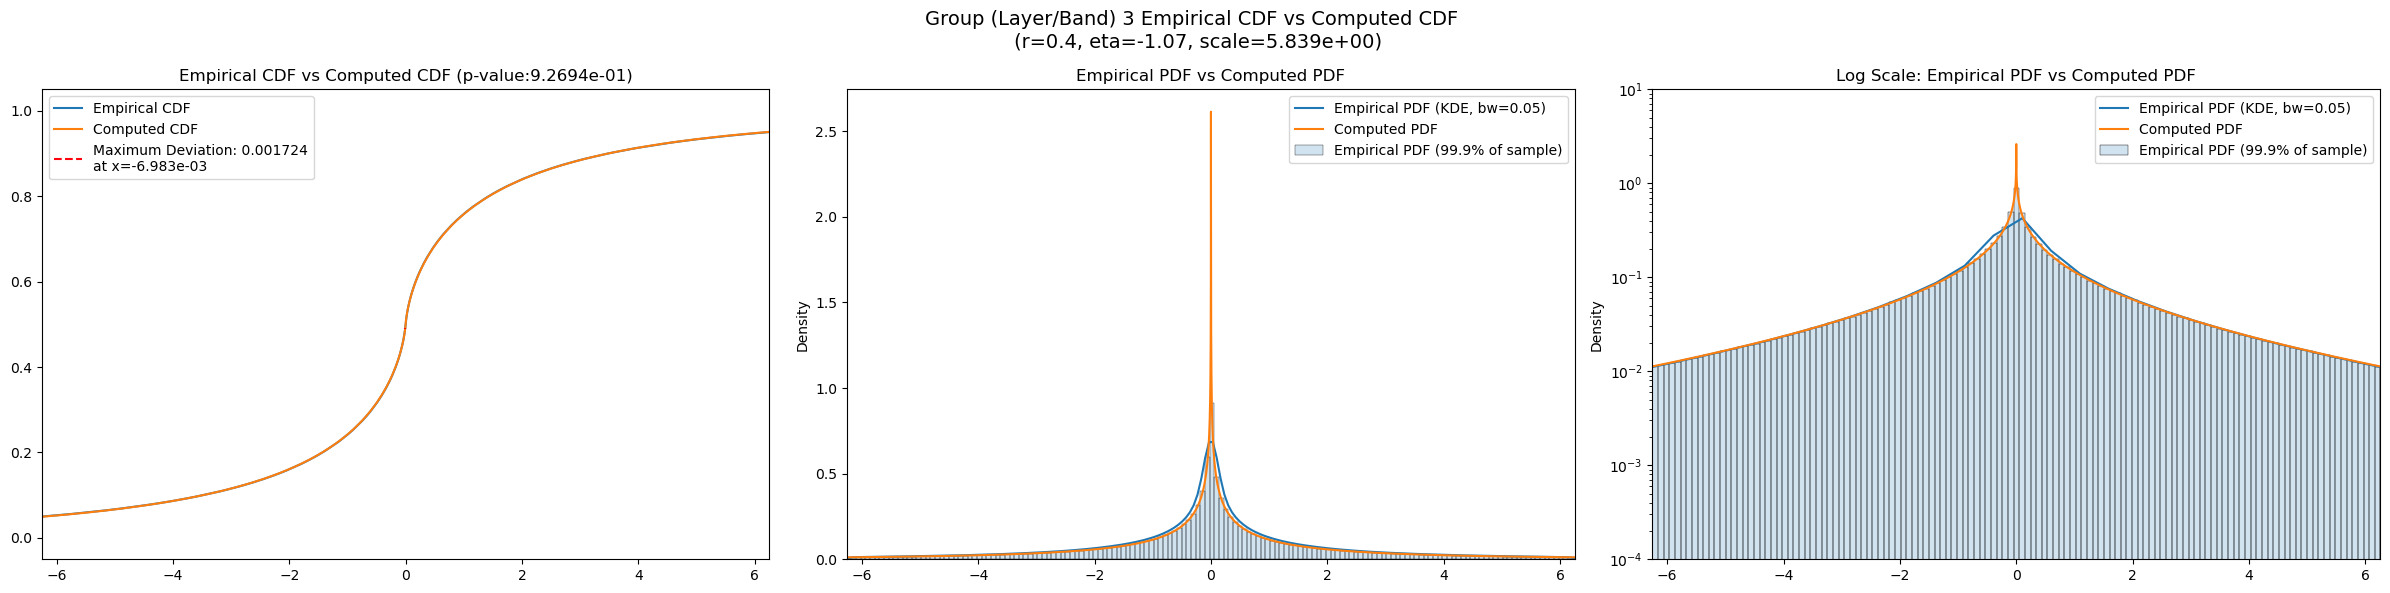

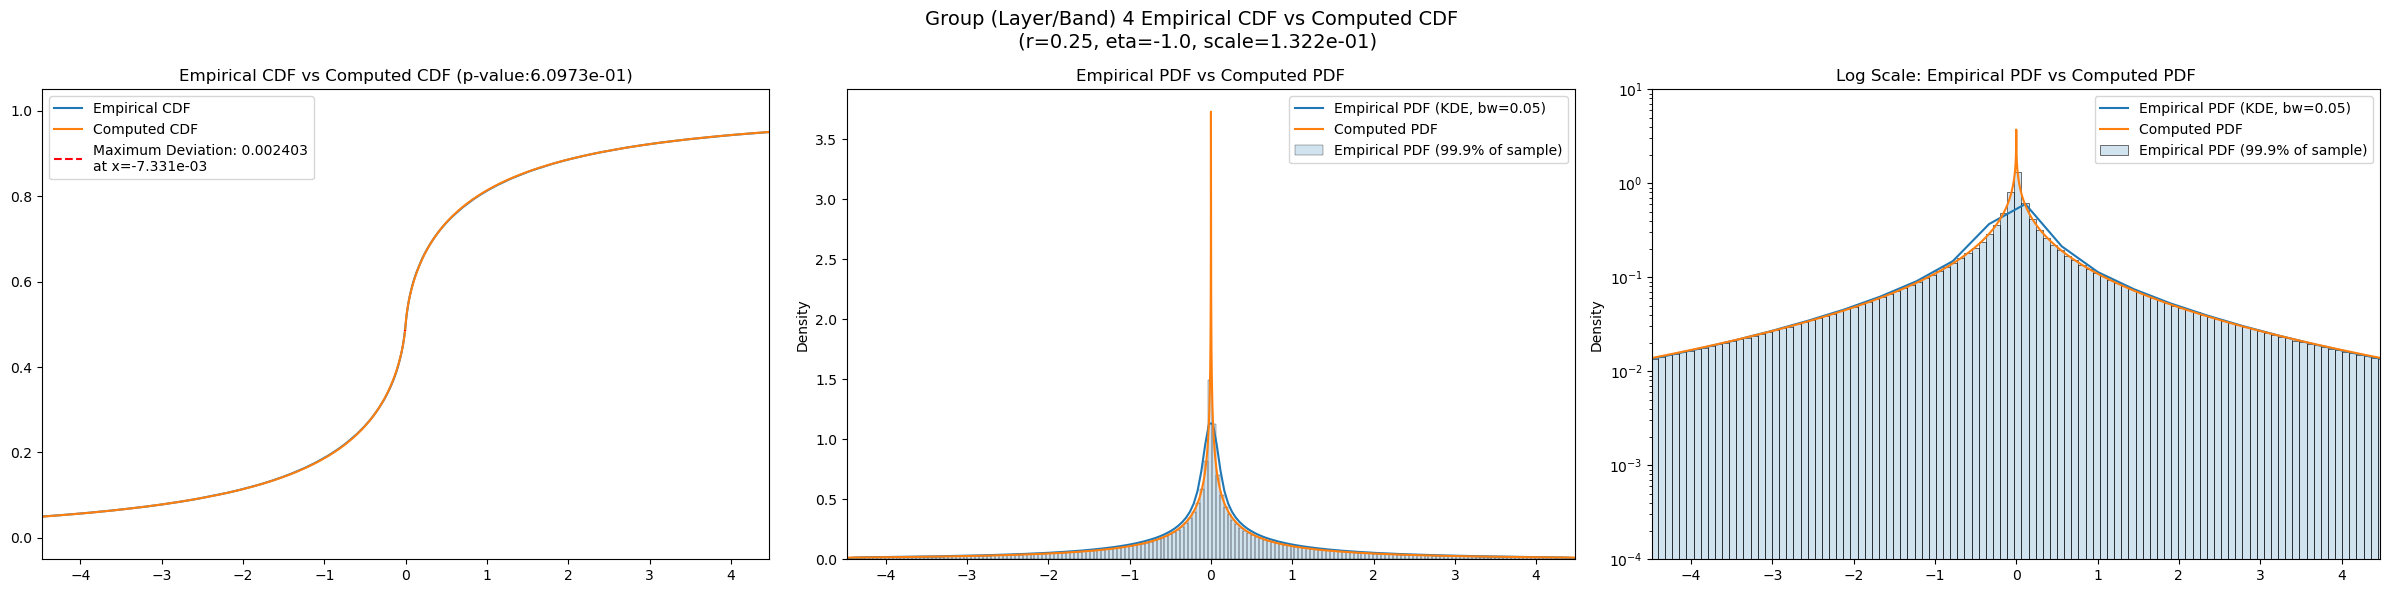

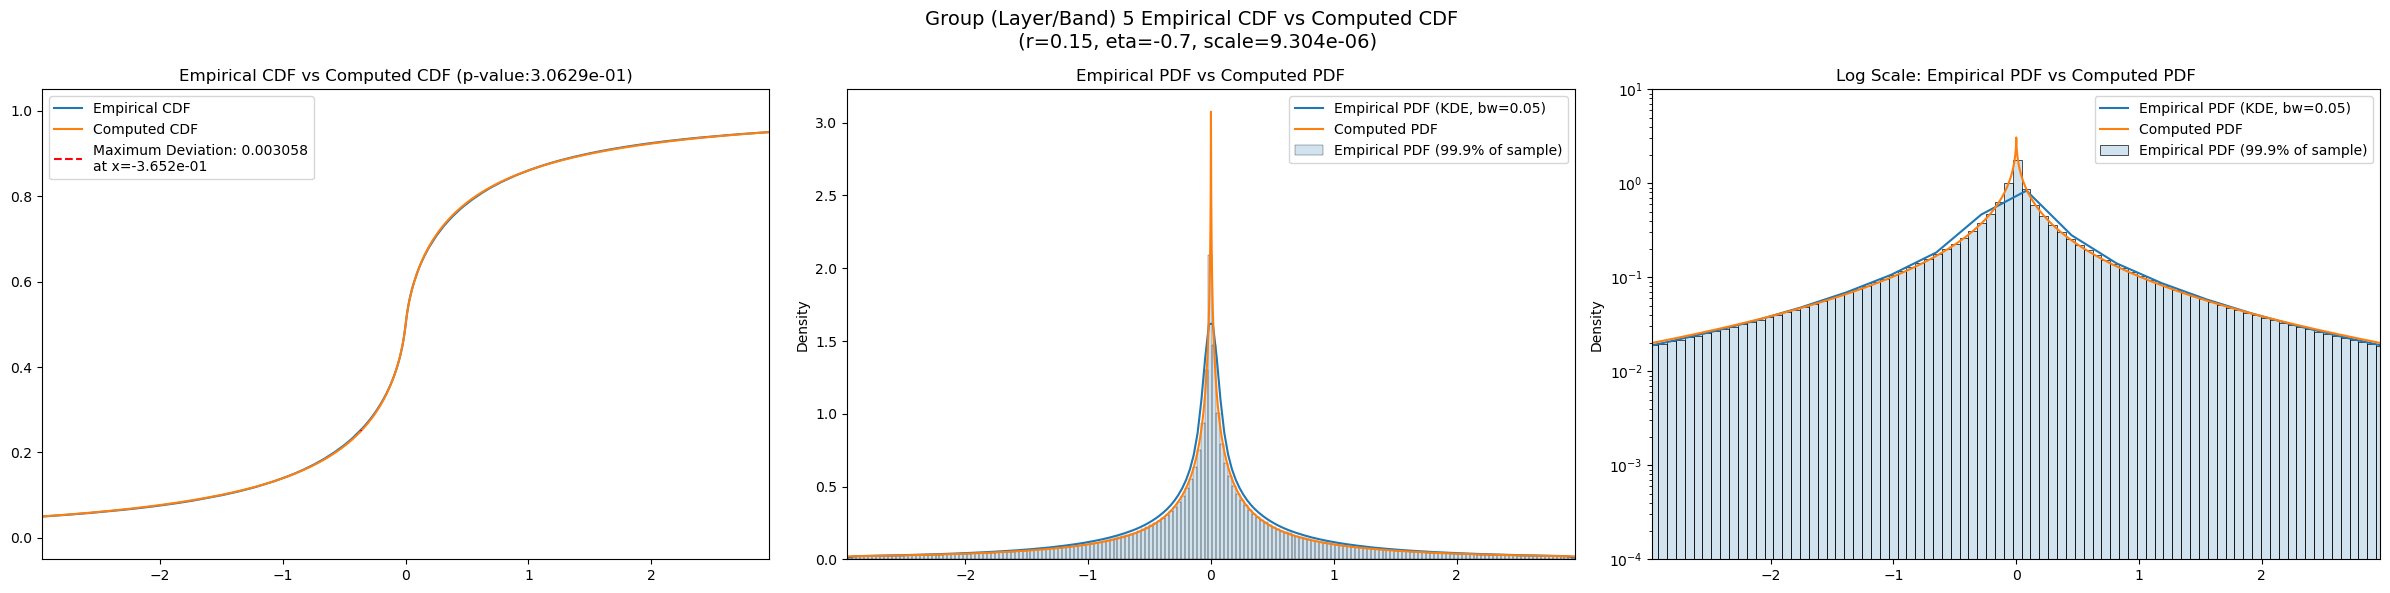

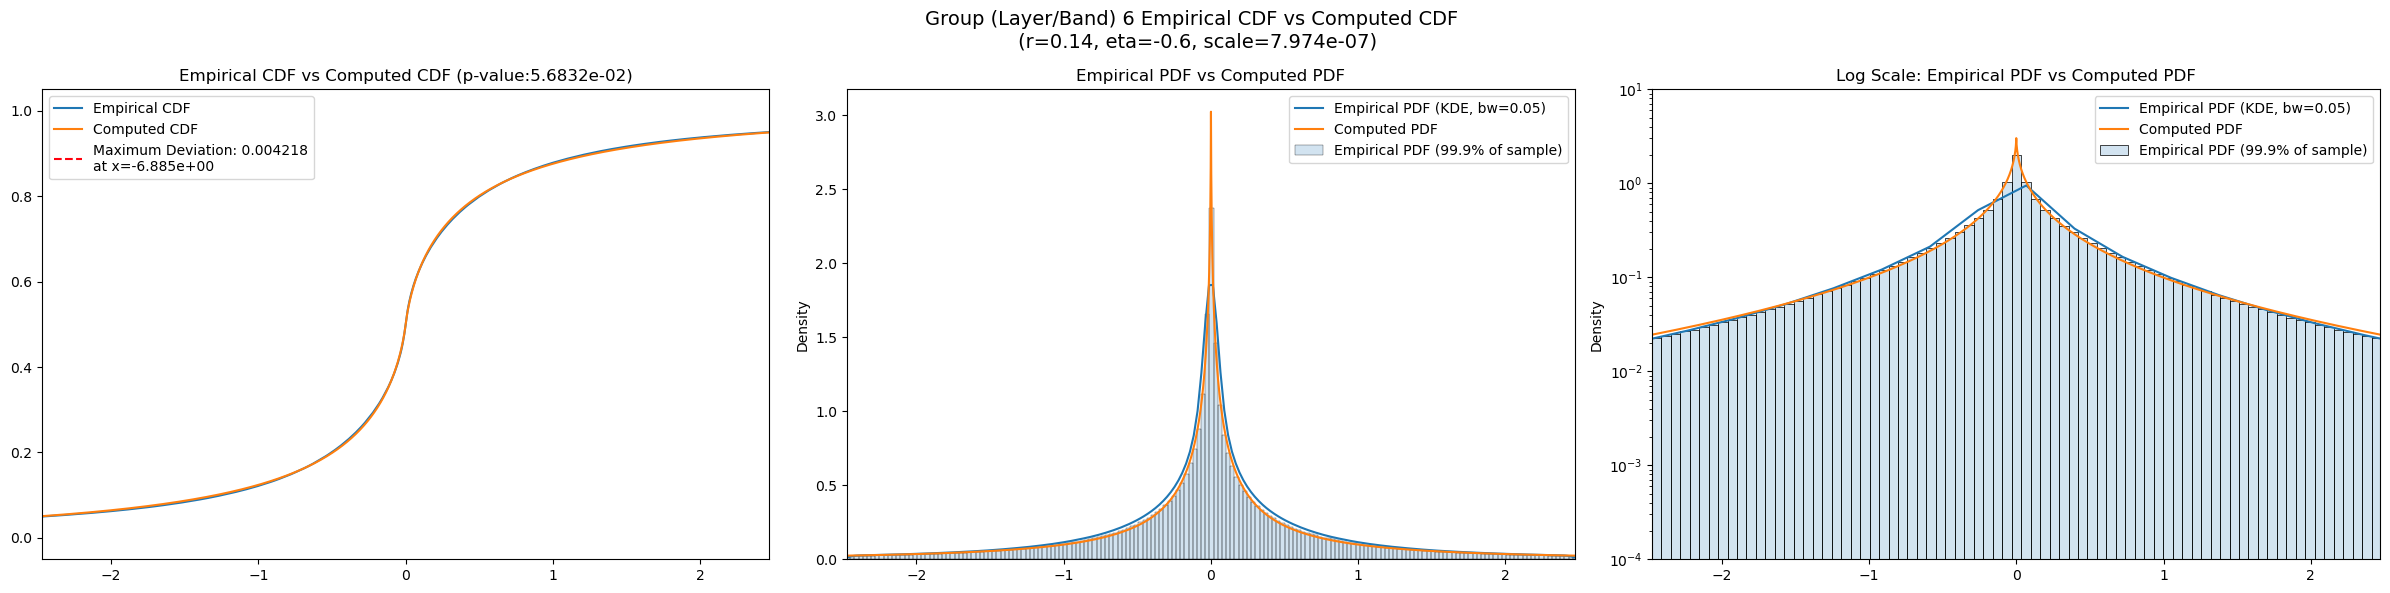

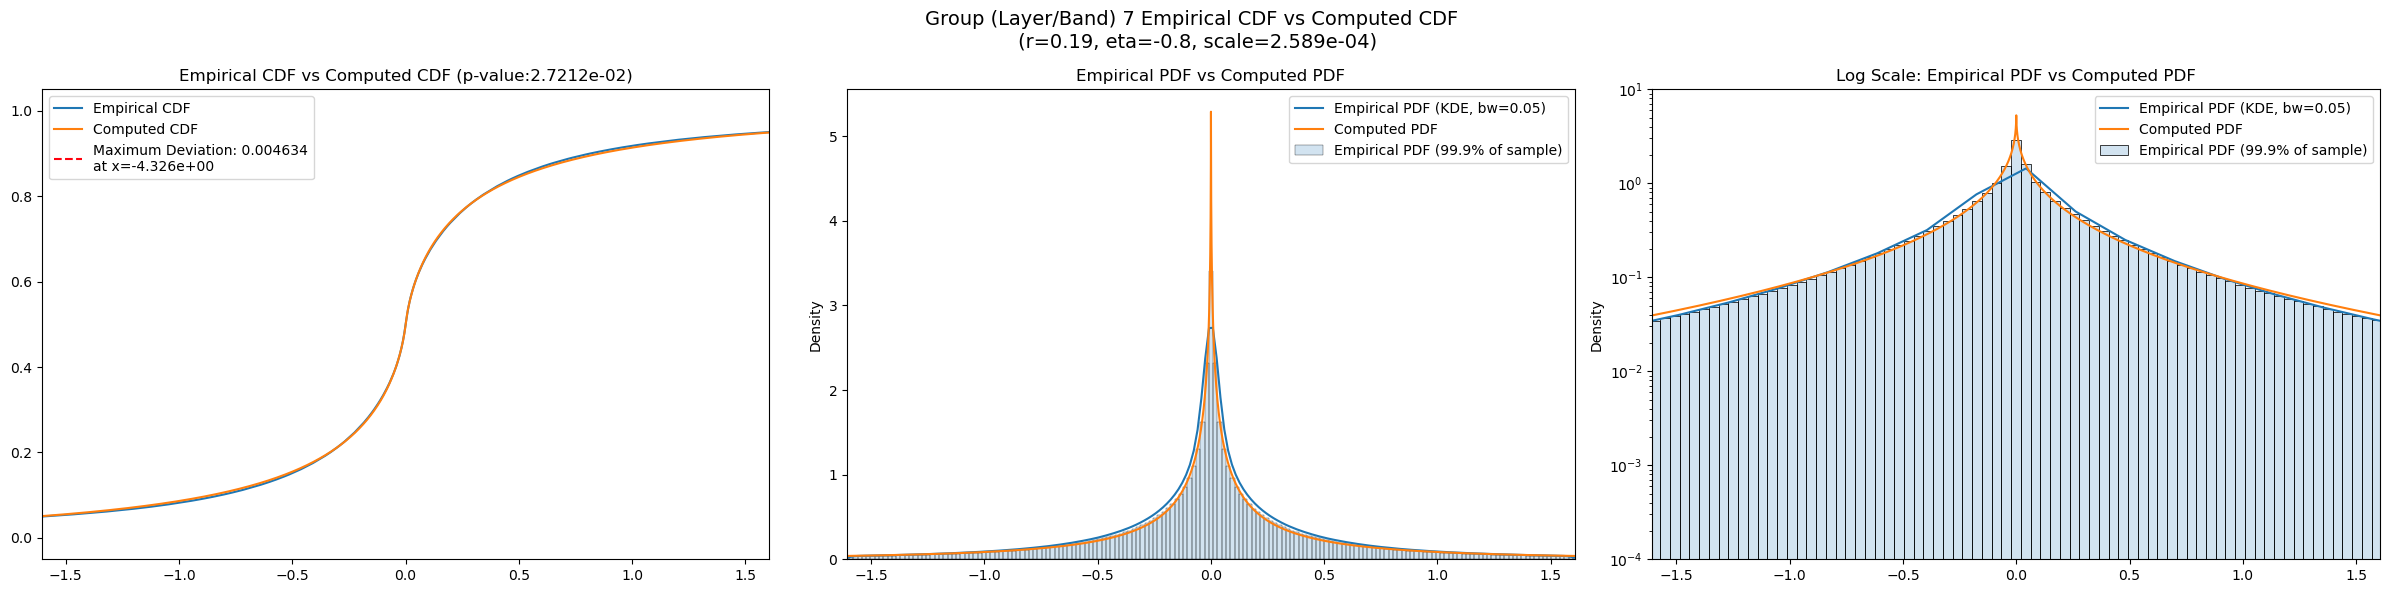

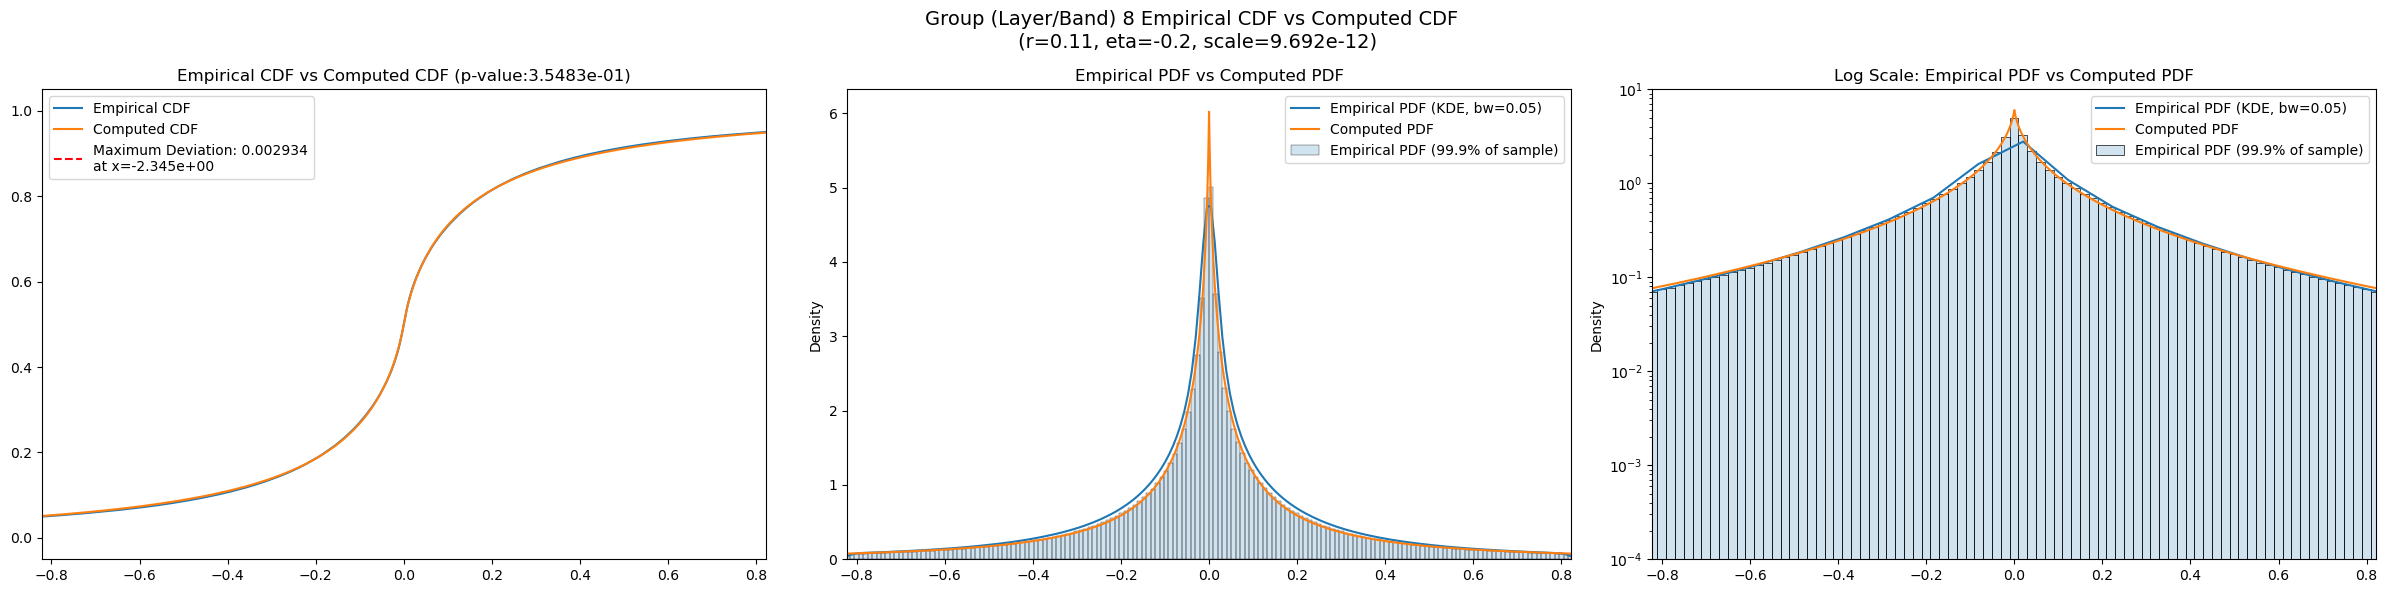

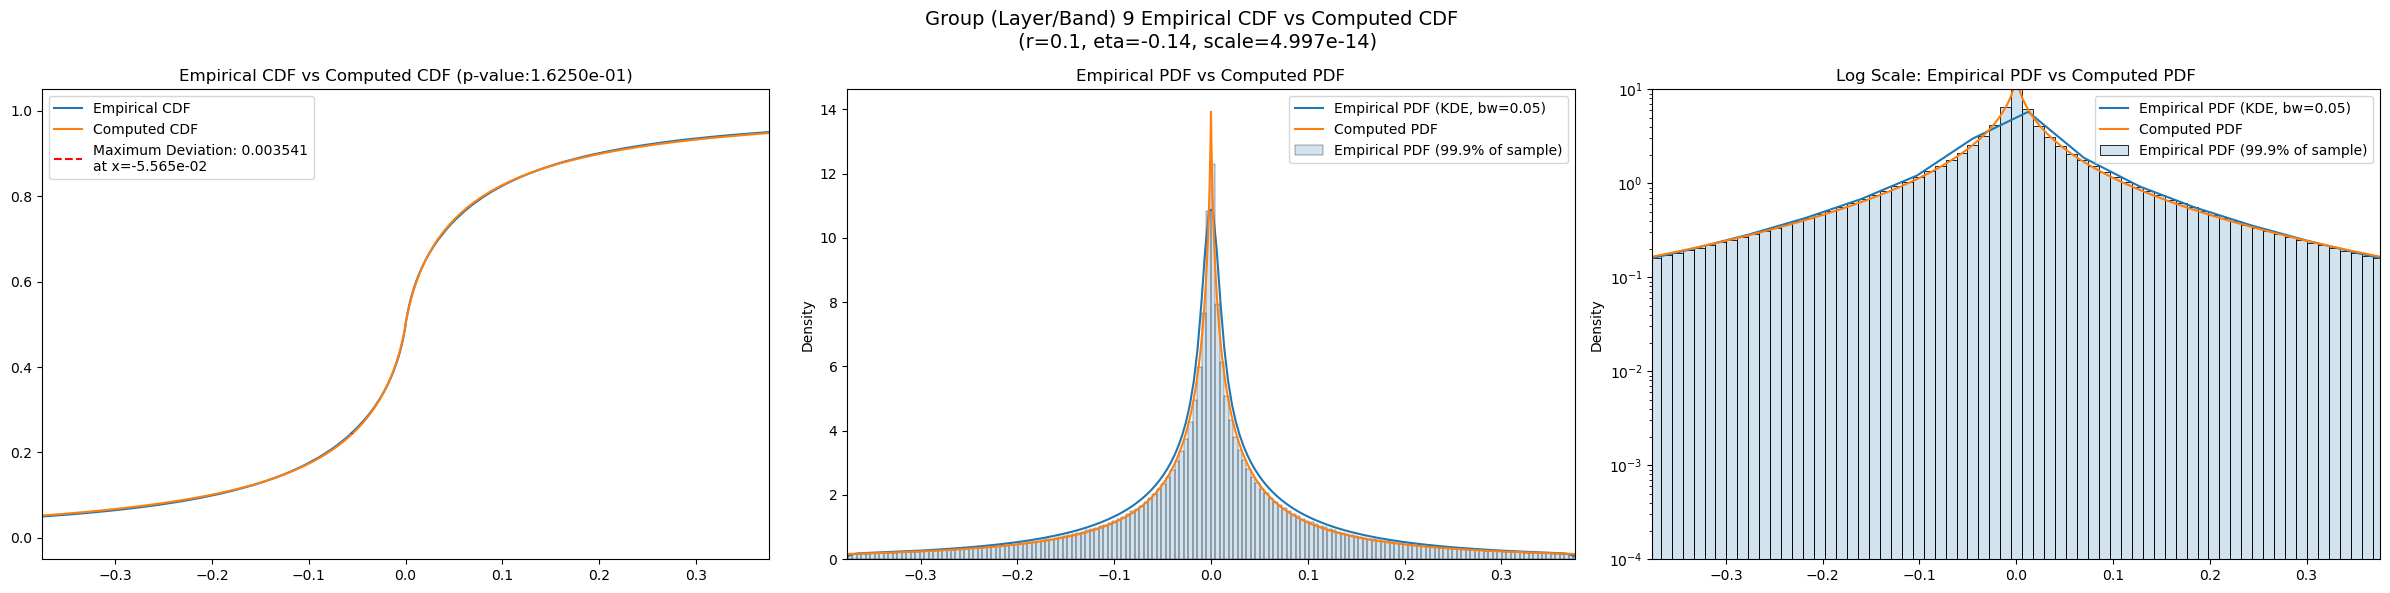

In [16]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [17]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [18]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var  var_lower  var_upper     obs_kurt  kurt_lower  kurt_upper  \
band                                                                         
2     57.704780  47.476635  76.398020    85.819220   20.804083   325.88730   
3     28.217304  23.017448  38.998640   109.013954   22.600456   428.96490   
4     19.802885  15.805842  27.547457   119.686070   31.191708   448.51685   
5     11.860390   9.280744  16.449108   127.357480   39.895786   435.14180   
6      9.950483   7.310499  18.875906   489.406600   41.010380  1448.79970   
7      3.988397   3.037800   5.719976   155.192670   44.948450   511.73193   
8      1.212791   0.702662   4.294569  3882.218500   40.366207  4814.17040   
9      0.259110   0.182862   0.496471   520.751400   54.998947  1529.40590   

      total_samples  kstest_stat_initial  initial_r  initial_eta  ...  \
band                                                              ...   
2        12192660.0             0.003900        0.4         -1.0  ...   
3        14450560.0             0.002512        0.3         -1.0  ...   
4        17611620.0             0.004897        0.2         -0.9  ...   
5        20772680.0             0.003471        0.2         -0.9  ...   
6        24836900.0             0.006113        0.1         -0.2  ...   
7        29804280.0             0.005717        0.2         -0.8  ...   
8        35674820.0             0.003074        0.1         -0.1  ...   
9        57350660.0             0.004268        0.1         -0.1  ...   

      param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band                                                               
2           2.731930              0.071043                   0.0   
3           1.786490              0.075340                   0.0   
4           1.113730              0.082163                   0.0   
5           0.742296              0.078902                   0.0   
6           0.642406              0.075666                   0.0   
7           0.427181              0.074087                   0.0   
8           0.230489              0.071421                   0.0   
9           0.104310              0.073336                   0.0   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace   param_t  \
band                                                                      
2          2.358690             0.045643                  0.0  1.830350   
3          1.529630             0.050503                  0.0  1.188300   
4          0.955024             0.057768                  0.0  0.734401   
5          0.642088             0.054298                  0.0  0.491837   
6          0.555576             0.051237                  0.0  0.425148   
7          0.370025             0.049559                  0.0  0.283108   
8          0.200803             0.046329                  0.0  0.154301   
9          0.090377             0.048261                  0.0  0.069701   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.046801            0.0          2.498016e-36  
3          0.052021            0.0          3.409712e-37  
4          0.058512            0.0          9.500827e-89  
5          0.054399            0.0         3.442473e-169  
6          0.051421            0.0          0.000000e+00  
7          0.049690            0.0          0.000000e+00  
8          0.046207            0.0         3.668067e-267  
9          0.048661            0.0          0.000000e+00  

[8 rows x 30 columns]

## Results

In [19]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [20]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
band                                                                   
2                0.003900                 0.000389          0.001841   
3                0.002512                 0.000357          0.001712   
4                0.004897                 0.000324          0.002403   
5                0.003471                 0.000298          0.003058   
6                0.006113                 0.000273          0.004218   
7                0.005717                 0.000249          0.004634   
8                0.003074                 0.000227          0.002934   
9                0.004268                 0.000179          0.003541   

      kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
band                                                            
2                 0.071043             0.045643       0.046801  
3                 0.075340             0.050503       0.052021  
4                 0.082163             0.057768       0.058512  
5                 0.078902             0.054298       0.054399  
6                 0.075666             0.051237       0.051421  
7                 0.074087             0.049559       0.049690  
8                 0.071421             0.046329       0.046207  
9                 0.073336             0.048261       0.048661

In [21]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
band                                                                         
2              47.455997          0.001841    0.36     -1.00  5.674268e+00   
3              21.932133          0.001712    0.40     -1.07  5.838624e+00   
4              15.865411          0.002403    0.25     -1.00  1.322118e-01   
5               9.254699          0.003058    0.15     -0.70  9.303887e-06   
6               6.466697          0.004218    0.14     -0.60  7.973980e-07   
7               2.278312          0.004634    0.19     -0.80  2.589221e-04   
8               0.699004          0.002934    0.11     -0.20  9.692276e-12   
9               0.165780          0.003541    0.10     -0.14  4.996840e-14   

      best_exclude_cutoff  
band                       
2                    50.0  
3                    75.0  
4                    50.0  
5                    50.0  
6                   100.0  
7                   175.0  
8                    50.0  
9                    75.0